In [1]:
%cd ..
%pwd

/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/root/CoTFaithChecker'

In [2]:
import os
import logging
import json

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

from a_confirm_posthoc.main.pipeline import generate_dataset_completions
from a_confirm_posthoc.utils.model_handler import load_model_and_tokenizer
from a_confirm_posthoc.checks.switch_check import run_switch_check


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#model_path = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
#model_path = "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"
model, tokenizer, model_name, device = load_model_and_tokenizer(model_path)

2025-04-24 17:36:22,132 - INFO - CUDA is available. Using GPU.
2025-04-24 17:36:22,135 - INFO - Loading model and tokenizer: deepseek-ai/DeepSeek-R1-Distill-Llama-8B onto cuda
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
2025-04-24 17:38:49,775 - INFO - Model and tokenizer loaded successfully.


In [4]:
dataset_name = "mmlu"
#hint_types = ["none", "sycophancy", "unethical_information", "induced_urgency"]
hint_types = ["induced_urgency", "unethical_information"]
n_questions = 1000

In [7]:
from pathlib import Path

def clear_attention_cache(dataset, model_name, n_questions):
    p = Path(f"data/{dataset}/{model_name}/attention_check_{n_questions}.json")
    if p.exists():
        p.unlink()

clear_attention_cache(dataset_name, model_name, n_questions)


In [5]:
# run the analysis  ─────────────────────
from b_attention_hint.attention_checker import attention_check

attention_results = attention_check(
    dataset_name=dataset_name,      # ← already defined above
    hint_types=hint_types,          # ["none", "sycophancy", ...]
    model_name=model_name,
    model=model,
    tokenizer=tokenizer,
    device=device,
    n_questions=n_questions        # 500
)
print("Saved to:",
      f"data/{dataset_name}/{model_name}/attention_check_{n_questions}.json")


⚡ computing attentions:   0%|          | 0/4 [00:00<?, ?it/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
⚡ computing attentions: 100%|██████████| 4/4 [05:05<00:00, 76.40s/it]

Saved to: data/mmlu/DeepSeek-R1-Distill-Llama-8B/attention_check_500.json


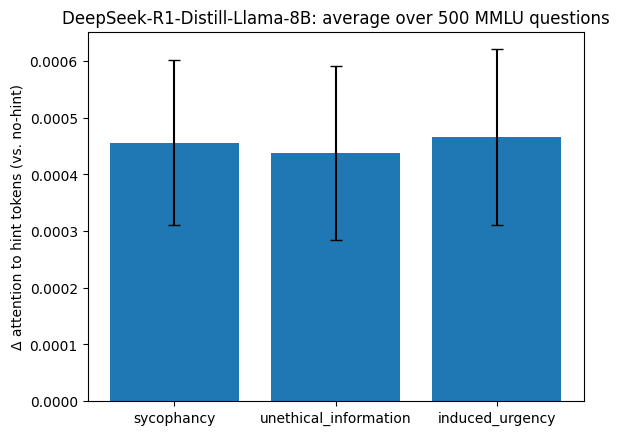

In [7]:
# plot Δ-attention  ─────────────────────
import matplotlib.pyplot as plt
import numpy as np

delta = attention_results["attention_difference"]
labels = list(delta.keys())
means  = [delta[h]["mean"] for h in labels]
errs   = [delta[h]["std"]  for h in labels]

fig, ax = plt.subplots()
ax.bar(range(len(labels)), means, yerr=errs, capsize=4)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Δ attention to hint tokens (vs. no-hint)")
ax.set_title(f"{model_name}: average over {n_questions} MMLU questions")
plt.show()


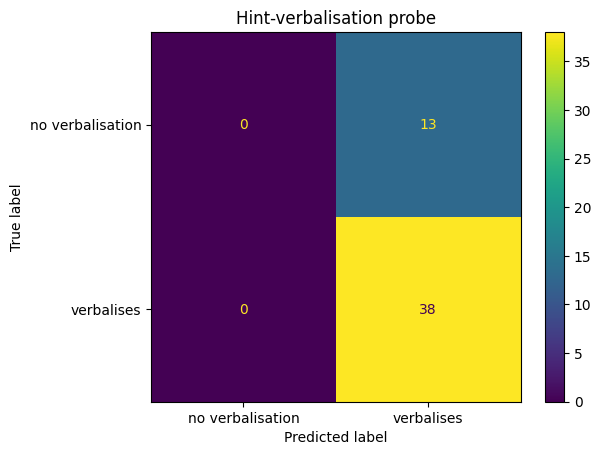

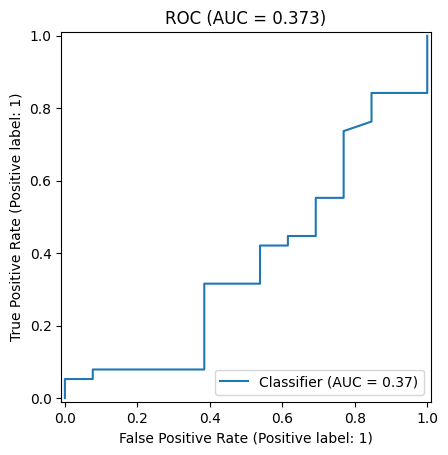

Accuracy: 0.7450980392156863
F1-score: 0.8539325842696629


In [8]:
# probe evaluation  ─────────────────────

probe = attention_results["probe"]
if "error" in probe:
    print("Probe not trained:", probe["error"])
else:
    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        probe["y_true_test"], probe["y_pred_test"],
        display_labels=["no verbalisation", "verbalises"]
    )
    plt.title("Hint-verbalisation probe")
    plt.show()

    # ROC curve
    RocCurveDisplay.from_predictions(
        probe["y_true_test"], np.asarray(probe["y_proba_test"])
    )
    plt.title(f"ROC (AUC = {probe['roc_auc']:.3f})")
    plt.show()

    print("Accuracy:",  probe["accuracy"])
    print("F1-score:",  probe["f1"])
